In [28]:
from hilbert_curve import hilbert_order, draw_curve_on_img, descriptor, histogram
from PIL import Image
import numpy as np
import cv2 as cv
from scipy.stats import skew, kurtosis, entropy, energy_distance
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
def pixel_values(img, curve_coordinates):

    curve_pixels = []
    np_img = np.asarray(img)
    
    for coord in curve_coordinates:
        curve_pixels.append(np_img[coord[1], coord[0]])
    
    return curve_pixels

### Leitura da imagem em escala de cinza

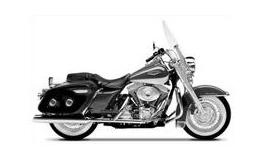

In [3]:
img = Image.open('../img/clean-bg/motorbike/image_0001.jpg').convert('L')
img

In [4]:
np.asarray(img)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### Curvas que passam por um ponto de interesse

In [5]:
kp = [10,10]

In [6]:
curves = []
masked_curves = []
images = []
n = 2

while n <= min(img.size):
    curve_coordinates = hilbert_order(n, img.size)
    draw = draw_curve_on_img(img, n)
    # draw.save(f'../img/hilbert/{n}.png')
    # print(np.sqrt(len(curve)))
    
    if kp in curve_coordinates:
        curve_pixels = pixel_values(img, curve_coordinates)
        curve_array = np.asarray(curve_pixels)

        masked_curves.append(ma.masked_greater(curve_array, 250))
        curves.append(curve_array)
        images.append(draw)
    
    n *= 2


In [7]:
plt.rcParams['figure.figsize'] = [20, 10]

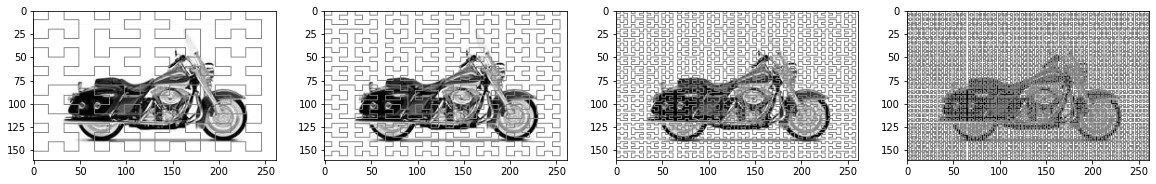

In [8]:
fig, axis = plt.subplots(1, len(images))

for i in range(len(images)):
    axis[i].imshow(images[i], cmap='gray')
plt.show()

### Gradiente de intensidade para cada curva

In [9]:
gradient = [np.gradient(x) for x in curves]

### Histograma de intensidade de cada curva

In [10]:
histograms = []

for curve in curves:
    h = np.zeros(256)
    
    for i in range(256):
        h[i] = int(np.count_nonzero(np.asarray(curve)==i))
        
    histograms.append(h)
    
masked_histograms = []
for curve in masked_curves:
    max_val = np.max(curve)
    h = np.zeros(max_val+1)
    
    for i in range(max_val+1):
        h[i] = int(np.count_nonzero(np.asarray(curve)==i))
        
    masked_histograms.append(h)


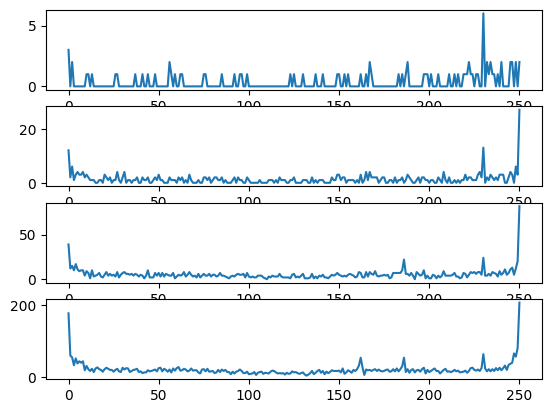

In [11]:
plt.rcdefaults()
fig, axis = plt.subplots(len(images))

for i in range(len(masked_histograms)):
    axis[i].plot(masked_histograms[i])
plt.show()

### Distrbuição de probabilidade de intensidade em cada curva

In [12]:
prob_distribution = []

for curve in masked_histograms:
    n_pixels = np.sum(curve)
    prob_distribution.append(np.asarray(curve)/n_pixels)

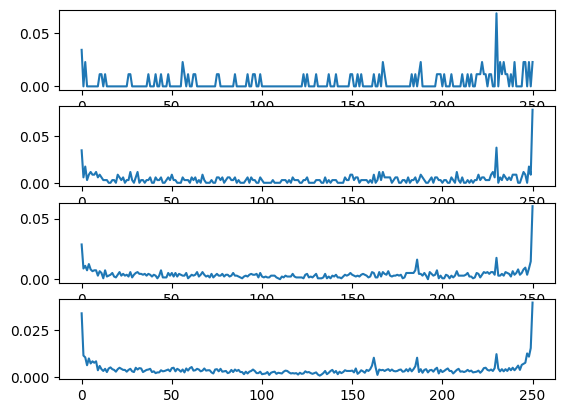

In [13]:
fig, axis = plt.subplots(len(prob_distribution))

for i in range(len(prob_distribution)):
    axis[i].plot(prob_distribution[i])
plt.show()

### Desvio Padrão

* Curva original

In [14]:
for curve in curves:
    print(np.std(curve))

66.84290160879762
75.80710030971336
76.10221001596598
76.51805176605251


* Gradiente

In [15]:
for curve in gradient: 
    print(np.std(curve))

35.51694138013576
30.58742912231265
25.37331862117296
20.926362038678107


### Assimetria

* Curva original

In [16]:
for curve in curves:
    print(skew(curve))

-2.111233282765976
-1.816647360160683
-1.7298892331954927
-1.7232997438780104


* Gradiente

In [17]:
for curve in gradient: 
    print(skew(curve))

-0.20383119571020605
-0.18028483060121803
0.020964756665177532
-0.10420211835584231


### Curtose

* Curva original

In [18]:
for curve in curves:
    print(kurtosis(curve))

3.2272605272207304
1.8230007627270428
1.5132903735071848
1.4772055695891426


* Gradiente

In [19]:
for g in gradient: 
    print(kurtosis(g))    

4.295573220846695
6.238109204785971
8.450844834807956
12.513826655678926


### Entropia

* Dsitribuição de probabilidade

In [20]:
for curve in prob_distribution: 
    print(entropy(curve))

4.1132423023923845
4.805346040149665
5.212886381299054
5.323675160757237


### Distância de Energia

* Curva original

In [21]:
for i in range(len(curves)-1):
    print(energy_distance(curves[i], curves[i+1]))

0.6404403792661197
0.18747456695999046
0.06601510132350541


* Gradiente

In [22]:
for i in range(len(gradient)-1):
    print(energy_distance(gradient[i], gradient[i+1]))

0.484847299978947
0.27336315779291326
0.2743355581049283


### Construindo o descritor com dados da curva original

In [30]:
desc = []

for i in range(len(curves)):

#     curve_info = []
    grad = np.gradient(curves[i])
    hist = histogram(curves[i])
    prob_dist = hist/np.sum(hist) 
    
    std1 = np.std(curves[i])
    std2 = np.std(grad)
            
    assi1 = skew(curves[i])
    assi2 = skew(grad)
            
    curt = kurtosis(prob_dist)
    entr = entropy(prob_dist)
    
#     curve_info.append(np.std(curves[i]))   # Desvio padrão da curva original
#     curve_info.append(np.std(gradient[i]))   # Desvio padrão do gradiente
    
#     curve_info.append(skew(curves[i]))     # Assimetria da curva original
#     curve_info.append(skew(gradient[i]))     # Assimetria do gradiente
    
#     curve_info.append(kurtosis(prob_distribution[i])) # Curtose da distribuição
#     curve_info.append(entropy(prob_distribution[i]))  # Entropia da distribuição
    
    desc.append(np.asarray([std1,std2,assi1,assi2,curt,entr]))

In [24]:
descriptor(img,kp)

array([[ 6.68429016e+01,  3.55169414e+01, -2.11123328e+00,
        -2.03831196e-01,  2.41539368e+02,  2.40910982e+00],
       [ 7.58071003e+01,  3.05874291e+01, -1.81664736e+00,
        -1.80284831e-01,  2.46968932e+02,  2.58557592e+00],
       [ 7.61022100e+01,  2.53733186e+01, -1.72988923e+00,
         2.09647567e-02,  2.47223448e+02,  2.70921055e+00],
       [ 7.65180518e+01,  2.09263620e+01, -1.72329974e+00,
        -1.04202118e-01,  2.46347346e+02,  2.69536895e+00]])